In [1]:
! pip install kagglehub

  Using cached kagglehub-0.3.13-py3-none-any.whl.metadata (38 kB)
Using cached kagglehub-0.3.13-py3-none-any.whl (68 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [kagglehub]/4 [kagglehub]


In [ ]:
import kagglehub
import shutil
import os

# Step 1: Download (Kaggle-controlled location)
src_path = kagglehub.dataset_download("mohamedadlyi/aflw2000-3d")

# Step 2: Move / copy to your desired folder
dst_path = "../dataset/aflw2000-3d"
os.makedirs(dst_path, exist_ok=True)

shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print("Dataset copied to:", dst_path)

Dataset copied to: ../dataset/aflw2000-3d


In [1]:
import sys
import os

ROOT_DIR = os.path.abspath("..")
sys.path.append(ROOT_DIR)

In [14]:
import yaml

def load_cfg(cfg_fp):
    with open(cfg_fp, "r") as f:
        return yaml.safe_load(f)


In [4]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import mediapipe as mp

from TDDFA import TDDFA
from FaceBoxes import FaceBoxes
from utils.tddfa_util import _parse_param

# ---------------------------
# Config
# ---------------------------
IMG_DIR = "../dataset/aflw2000-3d/AFLW2000"
OUT_DIR = "data"
os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Init models
# ---------------------------
mp_face = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True
)

tddfa = TDDFA(
    gpu_mode=True,
    arch="mobilenet",
    checkpoint_fp="../weights/mb1_120x120.pth"
)

face_boxes = FaceBoxes()

# ---------------------------
# Storage
# ---------------------------
all_landmarks = []
all_expr = []

# ---------------------------
# Process images
# ---------------------------
for img_name in tqdm(os.listdir(IMG_DIR)):
    if not img_name.lower().endswith((".jpg", ".png")):
        continue

    img_fp = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_fp)
    if img is None:
        continue

    h, w, _ = img.shape
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # MediaPipe landmarks
    results = mp_face.process(img_rgb)
    if not results.multi_face_landmarks:
        continue

    lm = results.multi_face_landmarks[0].landmark
    lm = np.array([[p.x * w, p.y * h, p.z * w] for p in lm]).flatten()
    all_landmarks.append(lm)

    # 3DDFA expression
    boxes = face_boxes(img)
    if len(boxes) == 0:
        all_landmarks.pop()
        continue

    param_lst, roi_box_lst = tddfa(img, [boxes[0]])
    _, _, _, alpha_exp = _parse_param(param_lst[0])
    all_expr.append(alpha_exp)

# ---------------------------
# Save
# ---------------------------
np.save(os.path.join(OUT_DIR, "landmarks.npy"), np.array(all_landmarks))
np.save(os.path.join(OUT_DIR, "expressions.npy"), np.array(all_expr))

print("Dataset created:")
print("Landmarks:", np.array(all_landmarks).shape)
print("Expressions:", np.array(all_expr).shape)


I0000 00:00:1768103332.151992    1610 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1768103332.180436    3638 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (AMD Radeon(TM) Graphics)
W0000 00:00:1768103332.190204    3624 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1768103332.216678    3623 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
100%|██████████| 4001/4001 [01:17<00:00, 51.80it/s]


Dataset created:
Landmarks: (1828, 1434)
Expressions: (1828, 10, 1)


In [77]:
X = np.load("data/landmarks.npy").astype(np.float32)
y = np.load("data/expressions.npy").astype(np.float32).squeeze(-1)


In [78]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [79]:
import mediapipe as mp
mp_face = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)
def extract_landmarks(image):
    results = mp_face.process(image)
    if not results.multi_face_landmarks:
        return None

    lm = results.multi_face_landmarks[0].landmark
    coords = np.array([[p.x, p.y, p.z] for p in lm])  # (468, 3)
    return coords

I0000 00:00:1767973657.712312   21748 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1767973657.741800  131254 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (AMD Radeon(TM) Graphics)


W0000 00:00:1767973657.750555  131240 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [80]:
import torch
from torch.utils.data import Dataset, DataLoader
class ExpressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])


In [81]:
train_ds = ExpressionDataset(X_train, y_train)
val_ds   = ExpressionDataset(X_val, y_val)


In [82]:
BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

W0000 00:00:1767973657.787810  131239 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [83]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# -------------------------------
# Config
# -------------------------------
DATA_DIR = "data"
LANDMARKS_FP = os.path.join(DATA_DIR, "landmarks.npy")
EXPRESSIONS_FP = os.path.join(DATA_DIR, "expressions.npy")
EPOCHS = 200
LR = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)
torch.set_grad_enabled(True)


class ExpressionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(478 * 3, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),

            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            nn.Linear(256, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

# -------------------------------
# Training
# -------------------------------
model = ExpressionHead().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LR ,weight_decay=1e-5)

best_val_loss = float("inf")

train_losses = []
val_losses   = []

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    total_loss = 0.0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        pred = model(x)
        loss = criterion(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Validate ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.6f}, val_loss={avg_val_loss:.6f}")

    # Save best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), os.path.join(SAVE_DIR, "expr_head_best.pth"))
        print(f"🔥 New best model saved @ epoch {epoch+1}")

# Final save
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "expr_head_final.pth"))
print("Training done!")

Epoch 1/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 211.33it/s]


Epoch 1: train_loss=0.378160, val_loss=0.351165
🔥 New best model saved @ epoch 1


Epoch 2/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 201.45it/s]


Epoch 2: train_loss=0.301029, val_loss=0.329599
🔥 New best model saved @ epoch 2


Epoch 3/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 321.67it/s]


Epoch 3: train_loss=0.239560, val_loss=0.309044
🔥 New best model saved @ epoch 3


Epoch 4/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 362.46it/s]


Epoch 4: train_loss=0.182637, val_loss=2.163517


Epoch 5/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 374.77it/s]


Epoch 5: train_loss=0.144156, val_loss=0.530877


Epoch 6/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 279.37it/s]


Epoch 6: train_loss=0.120919, val_loss=0.382222


Epoch 7/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 308.13it/s]


Epoch 7: train_loss=0.111047, val_loss=0.208003
🔥 New best model saved @ epoch 7


Epoch 8/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 279.10it/s]


Epoch 8: train_loss=0.099738, val_loss=0.159521
🔥 New best model saved @ epoch 8


Epoch 9/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 303.59it/s]


Epoch 9: train_loss=0.093429, val_loss=0.210839


Epoch 10/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 371.02it/s]


Epoch 10: train_loss=0.093877, val_loss=0.257239


Epoch 11/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 362.94it/s]


Epoch 11: train_loss=0.092155, val_loss=0.140321
🔥 New best model saved @ epoch 11


Epoch 12/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 337.76it/s]


Epoch 12: train_loss=0.089385, val_loss=0.191541


Epoch 13/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 296.19it/s]


Epoch 13: train_loss=0.085941, val_loss=0.134730
🔥 New best model saved @ epoch 13


Epoch 14/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 321.17it/s]


Epoch 14: train_loss=0.085545, val_loss=0.228323


Epoch 15/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 352.01it/s]


Epoch 15: train_loss=0.080033, val_loss=0.197211


Epoch 16/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 399.48it/s]


Epoch 16: train_loss=0.080296, val_loss=0.190833


Epoch 17/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 329.22it/s]


Epoch 17: train_loss=0.083701, val_loss=0.212600


Epoch 18/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 326.98it/s]


Epoch 18: train_loss=0.081830, val_loss=0.148780


Epoch 19/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 388.76it/s]


Epoch 19: train_loss=0.080343, val_loss=0.101774
🔥 New best model saved @ epoch 19


Epoch 20/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 355.08it/s]


Epoch 20: train_loss=0.078468, val_loss=0.190588


Epoch 21/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 412.65it/s]


Epoch 21: train_loss=0.077182, val_loss=0.093179
🔥 New best model saved @ epoch 21


Epoch 22/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 365.43it/s]


Epoch 22: train_loss=0.079505, val_loss=0.166933


Epoch 23/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 336.15it/s]


Epoch 23: train_loss=0.077294, val_loss=0.123368


Epoch 24/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 285.81it/s]


Epoch 24: train_loss=0.075932, val_loss=0.224345


Epoch 25/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 313.30it/s]


Epoch 25: train_loss=0.074792, val_loss=0.112540


Epoch 26/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 354.14it/s]


Epoch 26: train_loss=0.075815, val_loss=0.221542


Epoch 27/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 360.68it/s]


Epoch 27: train_loss=0.074634, val_loss=0.133311


Epoch 28/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 406.15it/s]


Epoch 28: train_loss=0.072966, val_loss=0.239019


Epoch 29/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 401.83it/s]


Epoch 29: train_loss=0.072346, val_loss=0.111833


Epoch 30/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 346.69it/s]


Epoch 30: train_loss=0.071923, val_loss=0.106019


Epoch 31/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 402.54it/s]


Epoch 31: train_loss=0.070151, val_loss=0.159309


Epoch 32/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 318.26it/s]


Epoch 32: train_loss=0.070173, val_loss=0.175327


Epoch 33/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 420.27it/s]


Epoch 33: train_loss=0.069123, val_loss=0.086739
🔥 New best model saved @ epoch 33


Epoch 34/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 566.42it/s]


Epoch 34: train_loss=0.069952, val_loss=0.175675


Epoch 35/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 426.01it/s]


Epoch 35: train_loss=0.070414, val_loss=0.123176


Epoch 36/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 431.10it/s]


Epoch 36: train_loss=0.071104, val_loss=0.204067


Epoch 37/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 507.83it/s]


Epoch 37: train_loss=0.066682, val_loss=0.084993
🔥 New best model saved @ epoch 37


Epoch 38/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 489.47it/s]


Epoch 38: train_loss=0.068350, val_loss=0.144174


Epoch 39/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 469.02it/s]


Epoch 39: train_loss=0.069859, val_loss=0.138475


Epoch 40/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 499.62it/s]


Epoch 40: train_loss=0.066796, val_loss=0.160389


Epoch 41/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 332.98it/s]


Epoch 41: train_loss=0.066868, val_loss=0.111357


Epoch 42/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 550.19it/s]


Epoch 42: train_loss=0.064409, val_loss=0.095567


Epoch 43/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 501.63it/s]


Epoch 43: train_loss=0.066673, val_loss=0.103755


Epoch 44/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 438.34it/s]


Epoch 44: train_loss=0.067032, val_loss=0.119357


Epoch 45/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 463.29it/s]


Epoch 45: train_loss=0.064927, val_loss=0.145470


Epoch 46/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 442.41it/s]


Epoch 46: train_loss=0.064308, val_loss=0.217342


Epoch 47/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 498.59it/s]


Epoch 47: train_loss=0.063037, val_loss=0.124179


Epoch 48/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 447.50it/s]


Epoch 48: train_loss=0.064942, val_loss=0.147237


Epoch 49/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 249.82it/s]


Epoch 49: train_loss=0.065248, val_loss=0.090682


Epoch 50/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 485.75it/s]


Epoch 50: train_loss=0.064561, val_loss=0.095316


Epoch 51/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 453.81it/s]


Epoch 51: train_loss=0.063015, val_loss=0.183617


Epoch 52/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 431.76it/s]


Epoch 52: train_loss=0.066474, val_loss=0.123694


Epoch 53/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 343.64it/s]


Epoch 53: train_loss=0.063782, val_loss=0.092190


Epoch 54/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 422.98it/s]


Epoch 54: train_loss=0.064472, val_loss=0.080283
🔥 New best model saved @ epoch 54


Epoch 55/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 387.56it/s]


Epoch 55: train_loss=0.063061, val_loss=0.121099


Epoch 56/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 359.32it/s]


Epoch 56: train_loss=0.064881, val_loss=0.087884


Epoch 57/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 375.60it/s]


Epoch 57: train_loss=0.064902, val_loss=0.162275


Epoch 58/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 498.12it/s]


Epoch 58: train_loss=0.061982, val_loss=0.159860


Epoch 59/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 487.73it/s]


Epoch 59: train_loss=0.062252, val_loss=0.164977


Epoch 60/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 484.95it/s]


Epoch 60: train_loss=0.064217, val_loss=0.345886


Epoch 61/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 418.62it/s]


Epoch 61: train_loss=0.065267, val_loss=0.137188


Epoch 62/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 498.83it/s]


Epoch 62: train_loss=0.064175, val_loss=0.108748


Epoch 63/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 466.86it/s]


Epoch 63: train_loss=0.066892, val_loss=0.086574


Epoch 64/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 348.84it/s]


Epoch 64: train_loss=0.062679, val_loss=0.114713


Epoch 65/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 440.33it/s]


Epoch 65: train_loss=0.062896, val_loss=0.109062


Epoch 66/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 468.31it/s]


Epoch 66: train_loss=0.063138, val_loss=0.285215


Epoch 67/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 517.22it/s]


Epoch 67: train_loss=0.063468, val_loss=0.273023


Epoch 68/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 426.81it/s]


Epoch 68: train_loss=0.062206, val_loss=0.098993


Epoch 69/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 484.63it/s]


Epoch 69: train_loss=0.059565, val_loss=0.110815


Epoch 70/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 504.95it/s]


Epoch 70: train_loss=0.058071, val_loss=0.115699


Epoch 71/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 462.66it/s]


Epoch 71: train_loss=0.057889, val_loss=0.207766


Epoch 72/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 479.09it/s]


Epoch 72: train_loss=0.060008, val_loss=0.105480


Epoch 73/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 466.07it/s]


Epoch 73: train_loss=0.059665, val_loss=0.115349


Epoch 74/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 479.46it/s]


Epoch 74: train_loss=0.059939, val_loss=0.141860


Epoch 75/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 467.09it/s]


Epoch 75: train_loss=0.058889, val_loss=0.114005


Epoch 76/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 472.62it/s]


Epoch 76: train_loss=0.060337, val_loss=0.157185


Epoch 77/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 465.93it/s]


Epoch 77: train_loss=0.056633, val_loss=0.212090


Epoch 78/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 450.85it/s]


Epoch 78: train_loss=0.059363, val_loss=0.108048


Epoch 79/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 458.49it/s]


Epoch 79: train_loss=0.057695, val_loss=0.143209


Epoch 80/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 475.69it/s]


Epoch 80: train_loss=0.058733, val_loss=0.112313


Epoch 81/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 395.98it/s]


Epoch 81: train_loss=0.057827, val_loss=0.105000


Epoch 82/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 314.38it/s]


Epoch 82: train_loss=0.056968, val_loss=0.202059


Epoch 83/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 446.30it/s]


Epoch 83: train_loss=0.056155, val_loss=0.089200


Epoch 84/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 452.72it/s]


Epoch 84: train_loss=0.057676, val_loss=0.084381


Epoch 85/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 447.19it/s]


Epoch 85: train_loss=0.056968, val_loss=0.168767


Epoch 86/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 469.88it/s]


Epoch 86: train_loss=0.056759, val_loss=0.151491


Epoch 87/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 492.98it/s]


Epoch 87: train_loss=0.056163, val_loss=0.094689


Epoch 88/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 419.89it/s]


Epoch 88: train_loss=0.057361, val_loss=0.166232


Epoch 89/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 466.21it/s]


Epoch 89: train_loss=0.054056, val_loss=0.135258


Epoch 90/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 493.83it/s]


Epoch 90: train_loss=0.056379, val_loss=0.086064


Epoch 91/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 458.64it/s]


Epoch 91: train_loss=0.054037, val_loss=0.087192


Epoch 92/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 477.69it/s]


Epoch 92: train_loss=0.054289, val_loss=0.091910


Epoch 93/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 461.47it/s]


Epoch 93: train_loss=0.056021, val_loss=0.088606


Epoch 94/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 476.73it/s]


Epoch 94: train_loss=0.059020, val_loss=0.192037


Epoch 95/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 439.95it/s]


Epoch 95: train_loss=0.056263, val_loss=0.131630


Epoch 96/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 436.41it/s]


Epoch 96: train_loss=0.055087, val_loss=0.085477


Epoch 97/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 454.54it/s]


Epoch 97: train_loss=0.057216, val_loss=0.088371


Epoch 98/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 481.90it/s]


Epoch 98: train_loss=0.054122, val_loss=0.113198


Epoch 99/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 350.13it/s]


Epoch 99: train_loss=0.055503, val_loss=0.196838


Epoch 100/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 404.47it/s]


Epoch 100: train_loss=0.055389, val_loss=0.126234


Epoch 101/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 451.76it/s]


Epoch 101: train_loss=0.055526, val_loss=0.161490


Epoch 102/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 341.75it/s]


Epoch 102: train_loss=0.055730, val_loss=0.108311


Epoch 103/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 454.86it/s]


Epoch 103: train_loss=0.056189, val_loss=0.165001


Epoch 104/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 446.58it/s]


Epoch 104: train_loss=0.053964, val_loss=0.149267


Epoch 105/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 447.04it/s]


Epoch 105: train_loss=0.053491, val_loss=0.127424


Epoch 106/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 484.01it/s]


Epoch 106: train_loss=0.056809, val_loss=0.083375


Epoch 107/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 462.59it/s]


Epoch 107: train_loss=0.058701, val_loss=0.196414


Epoch 108/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 429.03it/s]


Epoch 108: train_loss=0.053637, val_loss=0.210046


Epoch 109/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 457.39it/s]


Epoch 109: train_loss=0.053862, val_loss=0.096599


Epoch 110/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 387.50it/s]


Epoch 110: train_loss=0.055723, val_loss=0.126065


Epoch 111/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 435.09it/s]


Epoch 111: train_loss=0.052024, val_loss=0.098375


Epoch 112/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 289.75it/s]


Epoch 112: train_loss=0.049778, val_loss=0.094913


Epoch 113/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 427.22it/s]


Epoch 113: train_loss=0.051656, val_loss=0.088116


Epoch 114/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 329.57it/s]


Epoch 114: train_loss=0.054986, val_loss=0.125916


Epoch 115/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 456.76it/s]


Epoch 115: train_loss=0.050667, val_loss=0.106113


Epoch 116/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 398.91it/s]


Epoch 116: train_loss=0.054053, val_loss=0.115506


Epoch 117/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 436.54it/s]


Epoch 117: train_loss=0.052393, val_loss=0.105214


Epoch 118/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 471.76it/s]


Epoch 118: train_loss=0.051650, val_loss=0.176936


Epoch 119/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 443.28it/s]


Epoch 119: train_loss=0.053273, val_loss=0.118123


Epoch 120/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 467.49it/s]


Epoch 120: train_loss=0.050190, val_loss=0.130117


Epoch 121/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 453.72it/s]


Epoch 121: train_loss=0.051111, val_loss=0.123420


Epoch 122/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 499.28it/s]


Epoch 122: train_loss=0.050228, val_loss=0.096916


Epoch 123/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 374.56it/s]


Epoch 123: train_loss=0.049112, val_loss=0.088841


Epoch 124/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 460.58it/s]


Epoch 124: train_loss=0.051579, val_loss=0.109351


Epoch 125/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 442.73it/s]


Epoch 125: train_loss=0.048933, val_loss=0.115688


Epoch 126/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 423.87it/s]


Epoch 126: train_loss=0.048480, val_loss=0.088083


Epoch 127/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 468.13it/s]


Epoch 127: train_loss=0.053318, val_loss=0.096511


Epoch 128/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 503.08it/s]


Epoch 128: train_loss=0.051876, val_loss=0.095813


Epoch 129/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 511.67it/s]


Epoch 129: train_loss=0.052049, val_loss=0.275873


Epoch 130/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 461.98it/s]


Epoch 130: train_loss=0.049916, val_loss=0.114077


Epoch 131/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 487.60it/s]


Epoch 131: train_loss=0.049434, val_loss=0.126626


Epoch 132/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 345.61it/s]


Epoch 132: train_loss=0.049497, val_loss=0.098651


Epoch 133/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 442.95it/s]


Epoch 133: train_loss=0.048330, val_loss=0.176602


Epoch 134/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 446.54it/s]


Epoch 134: train_loss=0.049901, val_loss=0.127348


Epoch 135/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 420.73it/s]


Epoch 135: train_loss=0.051669, val_loss=0.082074


Epoch 136/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 279.17it/s]


Epoch 136: train_loss=0.050000, val_loss=0.132977


Epoch 137/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 409.59it/s]


Epoch 137: train_loss=0.049834, val_loss=0.158451


Epoch 138/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 408.75it/s]


Epoch 138: train_loss=0.050302, val_loss=0.111001


Epoch 139/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 390.35it/s]


Epoch 139: train_loss=0.048995, val_loss=0.195806


Epoch 140/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 460.64it/s]


Epoch 140: train_loss=0.049624, val_loss=0.148143


Epoch 141/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 503.68it/s]


Epoch 141: train_loss=0.048389, val_loss=0.100479


Epoch 142/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 380.52it/s]


Epoch 142: train_loss=0.047469, val_loss=0.094009


Epoch 143/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 451.66it/s]


Epoch 143: train_loss=0.046699, val_loss=0.178311


Epoch 144/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 438.18it/s]


Epoch 144: train_loss=0.049821, val_loss=0.178278


Epoch 145/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 456.95it/s]


Epoch 145: train_loss=0.049079, val_loss=0.107104


Epoch 146/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 399.15it/s]


Epoch 146: train_loss=0.049502, val_loss=0.139261


Epoch 147/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 455.13it/s]


Epoch 147: train_loss=0.050417, val_loss=0.091962


Epoch 148/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 504.91it/s]


Epoch 148: train_loss=0.049211, val_loss=0.179069


Epoch 149/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 248.18it/s]


Epoch 149: train_loss=0.049360, val_loss=0.094817


Epoch 150/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 409.31it/s]


Epoch 150: train_loss=0.048820, val_loss=0.125556


Epoch 151/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 408.42it/s]


Epoch 151: train_loss=0.047399, val_loss=0.097316


Epoch 152/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 357.13it/s]


Epoch 152: train_loss=0.047855, val_loss=0.254496


Epoch 153/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 492.29it/s]


Epoch 153: train_loss=0.047334, val_loss=0.264632


Epoch 154/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 346.31it/s]


Epoch 154: train_loss=0.047569, val_loss=0.080277
🔥 New best model saved @ epoch 154


Epoch 155/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 339.41it/s]


Epoch 155: train_loss=0.047575, val_loss=0.122401


Epoch 156/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 258.54it/s]


Epoch 156: train_loss=0.047767, val_loss=0.082364


Epoch 157/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 327.67it/s]


Epoch 157: train_loss=0.046305, val_loss=0.083846


Epoch 158/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 428.75it/s]


Epoch 158: train_loss=0.047255, val_loss=0.146118


Epoch 159/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 362.01it/s]


Epoch 159: train_loss=0.046870, val_loss=0.102360


Epoch 160/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 418.66it/s]


Epoch 160: train_loss=0.046028, val_loss=0.083625


Epoch 161/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 452.66it/s]


Epoch 161: train_loss=0.047481, val_loss=0.138470


Epoch 162/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 449.89it/s]


Epoch 162: train_loss=0.047238, val_loss=0.102343


Epoch 163/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 347.38it/s]


Epoch 163: train_loss=0.044414, val_loss=0.137591


Epoch 164/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 384.90it/s]


Epoch 164: train_loss=0.045563, val_loss=0.130588


Epoch 165/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 465.33it/s]


Epoch 165: train_loss=0.046824, val_loss=0.097170


Epoch 166/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 376.91it/s]


Epoch 166: train_loss=0.045953, val_loss=0.134176


Epoch 167/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 253.99it/s]


Epoch 167: train_loss=0.047331, val_loss=0.106823


Epoch 168/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 411.81it/s]


Epoch 168: train_loss=0.045172, val_loss=0.108929


Epoch 169/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 428.62it/s]


Epoch 169: train_loss=0.046127, val_loss=0.100021


Epoch 170/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 405.22it/s]


Epoch 170: train_loss=0.045379, val_loss=0.140759


Epoch 171/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 459.13it/s]


Epoch 171: train_loss=0.046567, val_loss=0.171987


Epoch 172/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 462.78it/s]


Epoch 172: train_loss=0.047247, val_loss=0.088824


Epoch 173/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 485.51it/s]


Epoch 173: train_loss=0.047386, val_loss=0.082729


Epoch 174/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 473.33it/s]


Epoch 174: train_loss=0.046504, val_loss=0.142673


Epoch 175/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 411.09it/s]


Epoch 175: train_loss=0.044567, val_loss=0.083569


Epoch 176/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 459.48it/s]


Epoch 176: train_loss=0.044773, val_loss=0.112945


Epoch 177/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 468.20it/s]


Epoch 177: train_loss=0.045516, val_loss=0.173561


Epoch 178/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 480.72it/s]


Epoch 178: train_loss=0.044442, val_loss=0.099617


Epoch 179/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 504.26it/s]


Epoch 179: train_loss=0.046894, val_loss=0.100154


Epoch 180/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 431.48it/s]


Epoch 180: train_loss=0.043966, val_loss=0.139692


Epoch 181/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 319.87it/s]


Epoch 181: train_loss=0.045219, val_loss=0.089036


Epoch 182/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 302.31it/s]


Epoch 182: train_loss=0.044979, val_loss=0.149383


Epoch 183/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 433.98it/s]


Epoch 183: train_loss=0.044998, val_loss=0.135978


Epoch 184/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 441.13it/s]


Epoch 184: train_loss=0.043313, val_loss=0.122091


Epoch 185/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 449.86it/s]


Epoch 185: train_loss=0.045405, val_loss=0.150404


Epoch 186/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 332.78it/s]


Epoch 186: train_loss=0.043024, val_loss=0.106629


Epoch 187/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 439.49it/s]


Epoch 187: train_loss=0.043418, val_loss=0.087363


Epoch 188/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 385.73it/s]


Epoch 188: train_loss=0.043685, val_loss=0.119034


Epoch 189/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 253.63it/s]


Epoch 189: train_loss=0.044174, val_loss=0.156184


Epoch 190/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 419.37it/s]


Epoch 190: train_loss=0.041650, val_loss=0.107323


Epoch 191/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 420.52it/s]


Epoch 191: train_loss=0.043325, val_loss=0.165023


Epoch 192/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 346.32it/s]


Epoch 192: train_loss=0.044748, val_loss=0.081470


Epoch 193/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 410.62it/s]


Epoch 193: train_loss=0.045112, val_loss=0.144712


Epoch 194/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 402.24it/s]


Epoch 194: train_loss=0.043767, val_loss=0.120869


Epoch 195/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 296.00it/s]


Epoch 195: train_loss=0.043219, val_loss=0.201480


Epoch 196/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 420.10it/s]


Epoch 196: train_loss=0.045289, val_loss=0.180857


Epoch 197/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 393.75it/s]


Epoch 197: train_loss=0.044087, val_loss=0.152371


Epoch 198/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 410.40it/s]


Epoch 198: train_loss=0.044428, val_loss=0.125659


Epoch 199/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 461.52it/s]


Epoch 199: train_loss=0.044769, val_loss=0.369893


Epoch 200/200 [Val]: 100%|██████████| 3/3 [00:00<00:00, 443.69it/s]

Epoch 200: train_loss=0.042692, val_loss=0.097720
Training done!


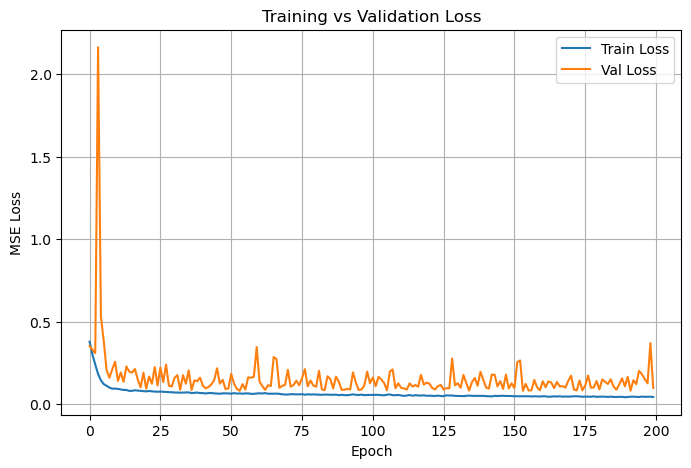

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
X = np.load("data/landmarks.npy").astype(np.float32)
y = np.load("data/expressions.npy").astype(np.float32).squeeze(-1)


In [86]:
ds = ExpressionDataset(X, y)
loader = DataLoader(ds, batch_size=128, shuffle=True)



======== GLOBAL METRICS ========
MSE  : 0.070524
MAE  : 0.136519
RMSE : 0.265563
R²   : 0.567081

---- Per Parameter MSE ----
Param 0: 0.422354
Param 1: 0.212706
Param 2: 0.011869
Param 3: 0.029323
Param 4: 0.001037
Param 5: 0.005767
Param 6: 0.007982
Param 7: 0.010604
Param 8: 0.000528
Param 9: 0.003065

Mean per-image MSE: 0.070523545
Worst sample MSE: 3.4134076


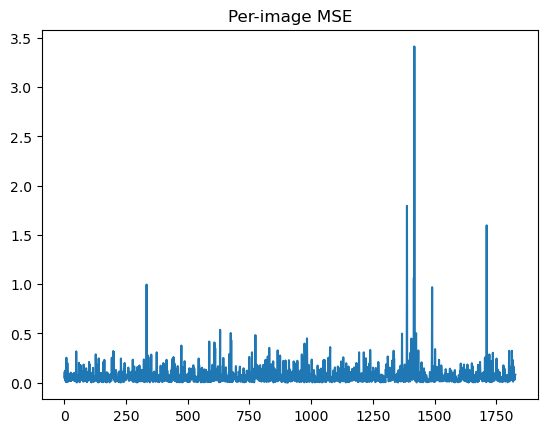

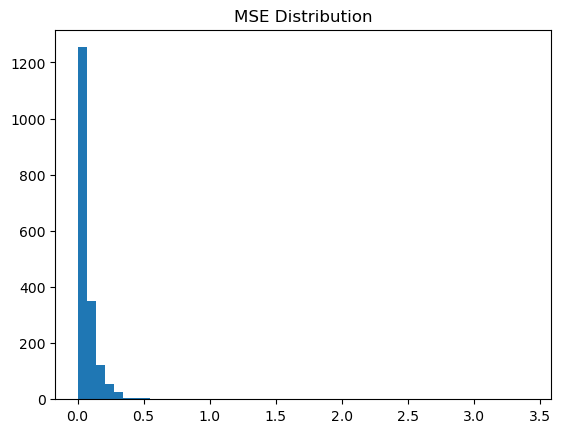

Saved per_image_mse.npy


In [87]:
from sklearn.metrics import mean_absolute_error, r2_score
MODEL_PATH = "./checkpoints/expr_head_final.pth"
# -------------------------------
# Data
# -------------------------------
X = np.load("data/landmarks.npy").astype(np.float32)
y = np.load("data/expressions.npy").astype(np.float32).squeeze(-1)

assert X.shape[0] == y.shape[0]
assert X.shape[1] == 478 * 3
assert y.shape[1] == 10

# -------------------------------
# Dataset + Dataloader
# -------------------------------
class ExpressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # index error safety
        idx = idx % len(self.X)
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.y[idx])

ds = ExpressionDataset(X, y)
loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False)

# -------------------------------
# Load model
# -------------------------------
model = ExpressionHead().to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

# -------------------------------
# Inference loop
# -------------------------------
all_preds = []
all_gts = []

with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        yp = model(xb).cpu().numpy()

        all_preds.append(yp)
        all_gts.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_gts = np.concatenate(all_gts,  axis=0)

# -------------------------------
# Metrics
# -------------------------------
mse  = ((all_preds - all_gts)**2).mean()
mae  = np.abs(all_preds - all_gts).mean()
rmse = np.sqrt(mse)
r2   = r2_score(all_gts, all_preds)

print("\n======== GLOBAL METRICS ========")
print(f"MSE  : {mse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")

# -------------------------------
# Per parameter error
# -------------------------------
per_dim_mse = ((all_preds - all_gts)**2).mean(axis=0)
print("\n---- Per Parameter MSE ----")
for i, v in enumerate(per_dim_mse):
    print(f"Param {i}: {v:.6f}")

# -------------------------------
# Per-image MSE
# -------------------------------
per_image_mse = ((all_preds - all_gts)**2).mean(axis=1)
print("\nMean per-image MSE:", per_image_mse.mean())
print("Worst sample MSE:", per_image_mse.max())

plt.figure()
plt.plot(per_image_mse)
plt.title("Per-image MSE")
plt.show()

plt.figure()
plt.hist(per_image_mse, bins=50)
plt.title("MSE Distribution")
plt.show()

np.save("per_image_mse.npy", per_image_mse)
print("Saved per_image_mse.npy")

In [88]:
import os
import cv2
import numpy as np
from tqdm import tqdm

from TDDFA import TDDFA
from FaceBoxes import FaceBoxes
from utils.tddfa_util import _parse_param

# -------------------------------
# Config
# -------------------------------
IMG_DIR = "../dataset/aflw2000-3d/AFLW2000"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tddfa = TDDFA(
    gpu_mode=True,
    arch="mobilenet",
    checkpoint_fp="../weights/mb1_120x120.pth"
)

face_boxes = FaceBoxes()

expr_list = []
fail_count = 0

# -------------------------------
# Collect 3DDFA expression params
# -------------------------------
for img_name in tqdm(os.listdir(IMG_DIR)):
    if not img_name.lower().endswith((".jpg", ".png")):
        continue

    img_path = os.path.join(IMG_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    boxes = face_boxes(img)
    if len(boxes) == 0:
        fail_count += 1
        continue

    param_lst, roi_box_lst = tddfa(img, [boxes[0]])

    # Parse expression params (alpha_exp)
    P, offset, angle, alpha_exp = _parse_param(param_lst[0])
    expr_list.append(alpha_exp)

expr_array = np.array(expr_list).astype(np.float32)

print(f"Done! Parsed {len(expr_array)} expression vectors")
print(f"Failed detection on {fail_count} images")

np.save("baseline_3ddfa_expr.npy", expr_array)


100%|██████████| 4001/4001 [01:06<00:00, 60.00it/s]

Done! Parsed 1964 expression vectors
Failed detection on 36 images



======== GLOBAL METRICS ========
MSE  : 0.550077
MAE  : 0.373496
RMSE : 0.741672
R²   : -0.972051

---- Per Parameter MSE ----
Param 0: 2.369816
Param 1: 2.608646
Param 2: 0.075787
Param 3: 0.254070
Param 4: 0.004013
Param 5: 0.026061
Param 6: 0.022917
Param 7: 0.106734
Param 8: 0.000816
Param 9: 0.031908

Mean per-image MSE: 0.55007714
Worst sample MSE: 6.362233


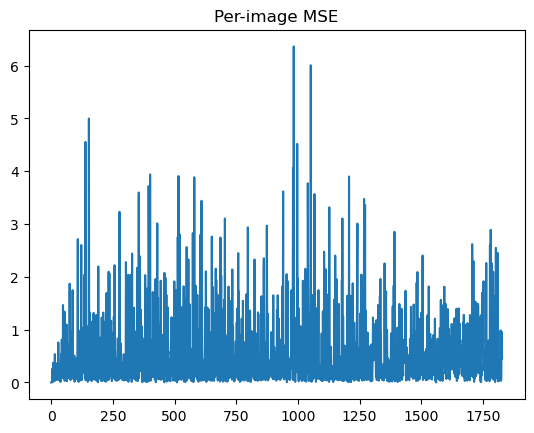

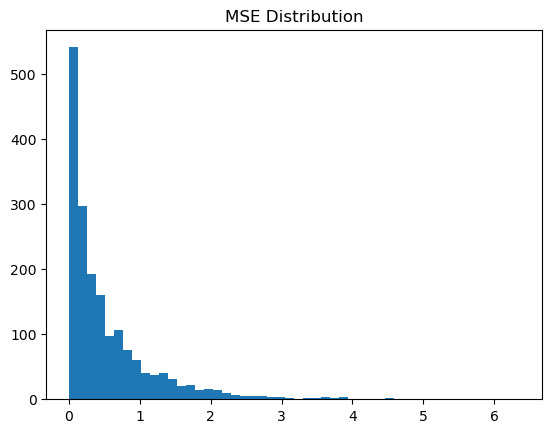

Saved per_image_mse.npy


In [89]:
baseline = np.load("baseline_3ddfa_expr.npy").squeeze(-1)
stored   = np.load("data/expressions.npy").squeeze(-1)

all_preds = baseline
all_gts   = stored

n = min(len(all_preds), len(all_gts))
all_preds = all_preds[:n]
all_gts   = all_gts[:n]

# -------------------------------
# Metrics
# -------------------------------
mse  = ((all_preds - all_gts)**2).mean()
mae  = np.abs(all_preds - all_gts).mean()
rmse = np.sqrt(mse)
r2   = r2_score(all_gts, all_preds)

print("\n======== GLOBAL METRICS ========")
print(f"MSE  : {mse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"RMSE : {rmse:.6f}")
print(f"R²   : {r2:.6f}")

# -------------------------------
# Per parameter error
# -------------------------------
per_dim_mse = ((all_preds - all_gts)**2).mean(axis=0)
print("\n---- Per Parameter MSE ----")
for i, v in enumerate(per_dim_mse):
    print(f"Param {i}: {v:.6f}")

# -------------------------------
# Per-image MSE
# -------------------------------
per_image_mse = ((all_preds - all_gts)**2).mean(axis=1)
print("\nMean per-image MSE:", per_image_mse.mean())
print("Worst sample MSE:", per_image_mse.max())

plt.figure()
plt.plot(per_image_mse)
plt.title("Per-image MSE")
plt.show()

plt.figure()
plt.hist(per_image_mse, bins=50)
plt.title("MSE Distribution")
plt.show()

np.save("per_image_mse.npy", per_image_mse)
print("Saved per_image_mse.npy")